## Module imports

In [1]:
# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path

if "notebooks" in str(Path.cwd()):
    chdir("..")


import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import src.constants as const
from src.schemas import DataCatalog
from src.various_methods import (
    PlotCounter,
    month_num_to_cos,
    month_num_to_sin,
    get_workingdays,
)
from src.simulation_schemas import PopulationScenarios

## Notebook Constants

In [2]:
OLD_AGE_OVER = 65
WORKING_AGE = 20
REGIONAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region"
APPOINTMENTS_START_DATE = dt.date(2022, 4, 1)
NOTEBOOK_ALIAS = "num_appointments"

## Load Catalog

In [3]:
# load data catalog
catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# Data loading
## Appointments SUB-ICB level

In [4]:
# this is the first in the dataset list
gp_appts_catalog_entry = catalog.get_catalog_entry_by_name(
    REGIONAL_APPOINTMENTS_CATALOG_NAME
)

snee_appointments_df = (
    gp_appts_catalog_entry.load()
)  # this loads the zipfile into instance variable
# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

all_area_appts_df = pd.concat(dfs, axis=0).assign(
    APPOINTMENT_MONTH=lambda df: pd.to_datetime(df.APPOINTMENT_MONTH)
)
all_area_appts_df.head()

/tmp/ipykernel_13967/162533508.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  APPOINTMENT_MONTH=lambda df: pd.to_datetime(df.APPOINTMENT_MONTH)


,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,8 to 14 Days,1101


## Exploration

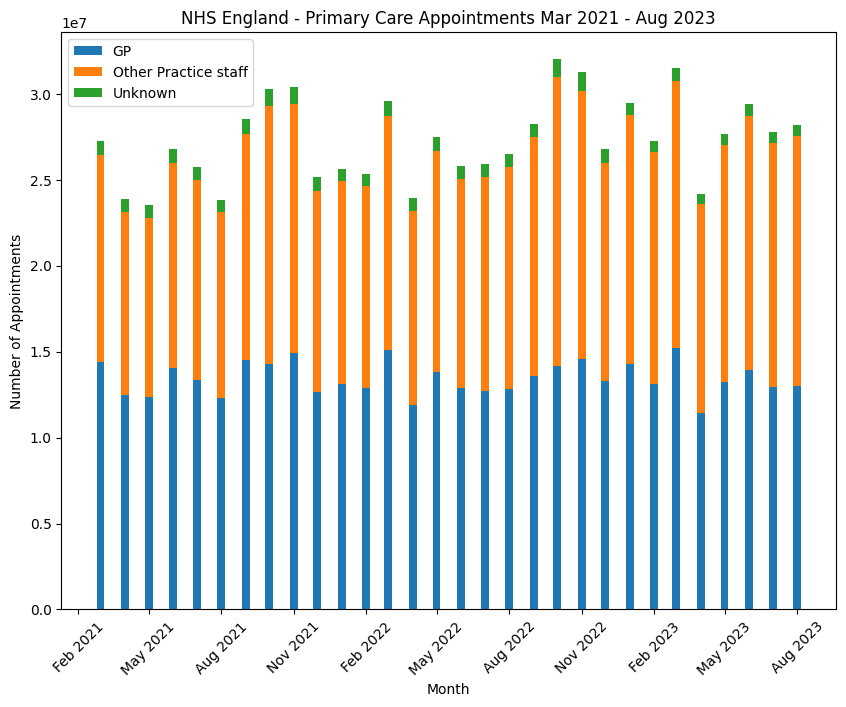

In [5]:
7


def stacked_bar_appointments(
    df: pd.DataFrame, title: str, ylabel: str, xlabel: str, figsize=(10, 7.5)
):
    fig, ax = plt.subplots(figsize=figsize)

    months = df["APPOINTMENT_MONTH"].unique()

    bottoms = np.zeros(len(months))
    for hcp_type in df["HCP_TYPE"].unique():
        hcp_type_slice = df[df["HCP_TYPE"] == hcp_type].copy()
        p = ax.bar(
            months,
            hcp_type_slice["COUNT_OF_APPOINTMENTS"].values,
            width=10,
            bottom=bottoms,
            label=hcp_type,
        )
        bottoms += hcp_type_slice["COUNT_OF_APPOINTMENTS"].values
    date_range = (
        str([f"{i.strftime('%b %Y')}" for i in [months.min(), months.max()]])[1:-1]
        .replace("'", "")
        .replace(",", " -")
    )
    ax.set_title(f"{title} {date_range}")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)
    ax.legend()
    plt.savefig(f"{plot_counter.plot_name}.png")
    plt.show()


stacked_bar_appointments(
    all_area_appts_df.groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[
        ["COUNT_OF_APPOINTMENTS"]
    ]
    .sum()
    .reset_index(),
    "NHS England - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

No obvious seasonality

In [6]:
all_area_appts_df

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,2021-03-01,Attended,GP,Face-to-Face,8 to 14 Days,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,92G,E38000231,NHS Bath and North East Somerset Swindon and W...,E54000040,"NHS Bath and North East Somerset, Swindon and ...",E40000006,South West,2023-08-01,Unknown,Unknown,Unknown,22 to 28 Days,202
5584,92G,E38000231,NHS Bath and North East Somerset Swindon and W...,E54000040,"NHS Bath and North East Somerset, Swindon and ...",E40000006,South West,2023-08-01,Unknown,Unknown,Unknown,8 to 14 Days,153
5585,92G,E38000231,NHS Bath and North East Somerset Swindon and W...,E54000040,"NHS Bath and North East Somerset, Swindon and ...",E40000006,South West,2023-08-01,Unknown,Unknown,Unknown,More than 28 Days,237
5586,92G,E38000231,NHS Bath and North East Somerset Swindon and W...,E54000040,"NHS Bath and North East Somerset, Swindon and ...",E40000006,South West,2023-08-01,Unknown,Unknown,Unknown,Same Day,40


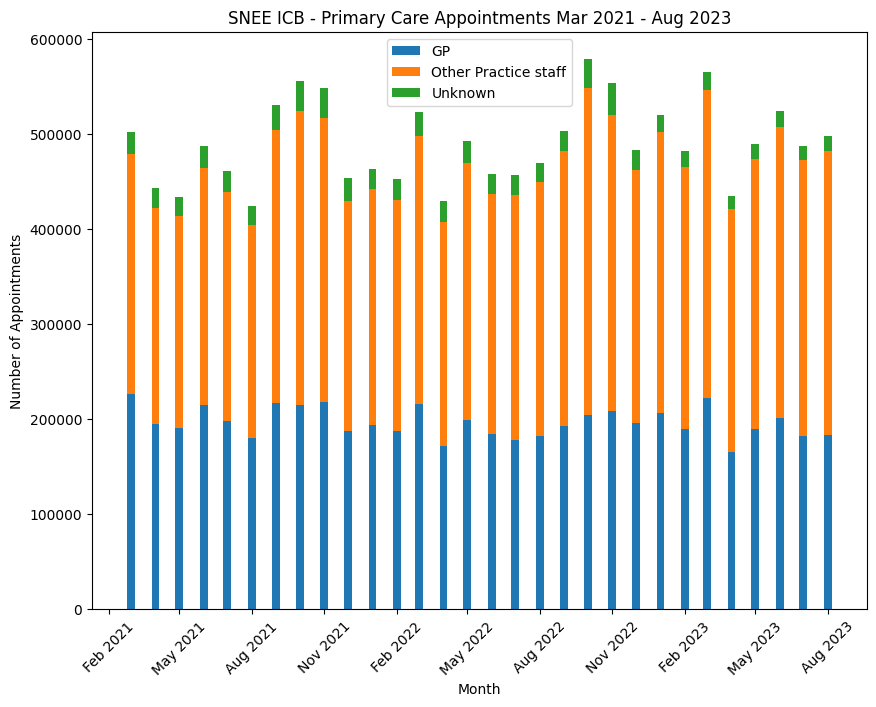

In [7]:
snee_appointments_df = (
    all_area_appts_df.loc[
        all_area_appts_df["SUB_ICB_LOCATION_CODE"].isin(
            list(const.SUB_ICB_CODES.keys())
        )
    ]
    .groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
stacked_bar_appointments(
    snee_appointments_df,
    "SNEE ICB - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

## load GP lists data for all areas

In [8]:
gp_list_df = catalog.get_catalog_entry_by_name(
    "Patients Registered at a GP practice, October 2023"
).load()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


## Feature Engineering

### Convert population to proportions of population

In [9]:
# keep gendered data, and age groups
gp_list_df = gp_list_df.loc[
    (gp_list_df["ORG_TYPE"] == "SUB_ICB_LOCATION")
    & (gp_list_df["SEX"] != "ALL")
    & (gp_list_df["AGE_GROUP_5"] != "ALL")
]
# drop all columns except these
gp_list_df = gp_list_df.loc[:, ["ORG_CODE", "SEX", "AGE_GROUP_5", "NUMBER_OF_PATIENTS"]]
# collapse 90-94 and 95-99 into 90+
gp_list_df["AGE_GROUP_5"] = gp_list_df["AGE_GROUP_5"].replace(
    {"90_94": "90+", "95+": "90+"}
)
# change _ to -
gp_list_df["AGE_GROUP_5"] = gp_list_df["AGE_GROUP_5"].str.replace("_", "-")
# pivot table to get age group as columns
gp_list_df = gp_list_df.pivot_table(
    index="ORG_CODE", columns="AGE_GROUP_5", values="NUMBER_OF_PATIENTS", aggfunc="sum"
)
# get the total list size by area
gp_list_size_by_area = gp_list_df.sum(axis=1)
gp_list_size_by_area.name = "gp_list_size"
# divide each age group by the total list size
gp_list_demographic_df = gp_list_df.div(gp_list_size_by_area, axis=0)

gp_list_demographic_df

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,0.055354,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00N,0.046318,0.056702,0.052957,0.048391,0.058945,0.071641,0.073194,0.066699,0.056026,0.054780,0.066198,0.072568,0.070651,0.060197,0.049951,0.042973,0.025699,0.017080,0.009032
00P,0.045493,0.056224,0.055058,0.054358,0.066509,0.074500,0.071698,0.064883,0.055768,0.052966,0.067178,0.069287,0.066296,0.058151,0.049276,0.042159,0.025396,0.016355,0.008447
00Q,0.056114,0.073327,0.069254,0.062584,0.067123,0.071613,0.073718,0.071445,0.061244,0.067286,0.065642,0.061721,0.053456,0.043510,0.036411,0.030505,0.018341,0.010841,0.005862
00R,0.046429,0.056044,0.054101,0.050338,0.059426,0.070912,0.069837,0.062282,0.055081,0.054717,0.069495,0.076881,0.070049,0.057242,0.047807,0.045427,0.028257,0.017382,0.008293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D9Y0V,0.044754,0.057723,0.054875,0.056655,0.061111,0.066157,0.066390,0.064362,0.059042,0.053581,0.065510,0.069489,0.065309,0.054914,0.050100,0.049306,0.030324,0.019025,0.011373
M1J4Y,0.056761,0.067081,0.059510,0.054228,0.068206,0.077507,0.081208,0.077654,0.066476,0.064680,0.064208,0.061501,0.053169,0.042478,0.036131,0.031448,0.019132,0.012090,0.006532
M2L0M,0.044474,0.058734,0.057799,0.048705,0.055575,0.062171,0.062580,0.059900,0.056298,0.053308,0.069734,0.074576,0.069721,0.058681,0.054886,0.051284,0.032140,0.018948,0.010486


#### Find total appointments per sub-icb per month with the list size

In [10]:
# total appointments per sub-icb per month with the list size
all_area_appts_df = (
    all_area_appts_df.loc[
        :, ["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH", "COUNT_OF_APPOINTMENTS"]
    ]
    .groupby(["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
all_area_appts_df = (
    all_area_appts_df.set_index("SUB_ICB_LOCATION_CODE")
    .join(gp_list_size_by_area)
    .reset_index()
)
all_area_appts_df

,index,APPOINTMENT_MONTH,COUNT_OF_APPOINTMENTS,gp_list_size
0,00L,2021-03-01,161182,337246
1,00L,2021-04-01,148441,337246
2,00L,2021-05-01,148804,337246
3,00L,2021-06-01,164539,337246
4,00L,2021-07-01,153725,337246
...,...,...,...,...
3175,X2C4Y,2023-04-01,212830,457030
3176,X2C4Y,2023-05-01,249359,457030
3177,X2C4Y,2023-06-01,267312,457030
3178,X2C4Y,2023-07-01,257789,457030


#### Number of appointments per month per person

In [11]:
# calculate appointments per person per month
all_area_appts_df = all_area_appts_df.assign(
    gp_appts_per_person=lambda df: df["COUNT_OF_APPOINTMENTS"] / df["gp_list_size"]
).drop(columns=["COUNT_OF_APPOINTMENTS", "gp_list_size"])
all_area_appts_df

,index,APPOINTMENT_MONTH,gp_appts_per_person
0,00L,2021-03-01,0.477936
1,00L,2021-04-01,0.440156
2,00L,2021-05-01,0.441233
3,00L,2021-06-01,0.487890
4,00L,2021-07-01,0.455825
...,...,...,...
3175,X2C4Y,2023-04-01,0.465681
3176,X2C4Y,2023-05-01,0.545608
3177,X2C4Y,2023-06-01,0.584889
3178,X2C4Y,2023-07-01,0.564053


### Add Working days/month
- Calculate appointments per working day
- drop unused columns

In [12]:
# get working days/month
all_area_appts_df["working_days"] = get_workingdays(
    all_area_appts_df["APPOINTMENT_MONTH"].dt
)
# calculate appointments per person per working day
all_area_appts_df["appts_per_person_per_workingday"] = (
    all_area_appts_df["gp_appts_per_person"] / all_area_appts_df["working_days"]
)
# get the month as a number
all_area_appts_df["month"] = all_area_appts_df["APPOINTMENT_MONTH"].dt.month
# drop columns
all_area_appts_df = all_area_appts_df.drop(
    columns=["working_days", "gp_appts_per_person", "APPOINTMENT_MONTH"]
)
all_area_appts_df

,index,appts_per_person_per_workingday,month
0,00L,0.020780,3
1,00L,0.020960,4
2,00L,0.023223,5
3,00L,0.022177,6
4,00L,0.020719,7
...,...,...,...
3175,X2C4Y,0.024510,4
3176,X2C4Y,0.027280,5
3177,X2C4Y,0.026586,6
3178,X2C4Y,0.026860,7


In [13]:
complete_dataset_df = all_area_appts_df.set_index("index").join(gp_list_demographic_df)

complete_dataset_df

,appts_per_person_per_workingday,month,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
00L,0.020780,3,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.020960,4,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023223,5,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.022177,6,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.020719,7,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2C4Y,0.024510,4,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.027280,5,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.026586,6,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.026860,7,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression

# remove SNEE ICBs from training set
training_dataset = complete_dataset_df.loc[
    ~complete_dataset_df.index.isin(list(const.SUB_ICB_CODES.keys()))
].copy()
test_set = complete_dataset_df.loc[
    complete_dataset_df.index.isin(list(const.SUB_ICB_CODES.keys()))
].copy()


# Split the dataset into features (X) and target variable (y)
X = complete_dataset_df.drop(columns=["appts_per_person_per_workingday"])
y = complete_dataset_df["appts_per_person_per_workingday"]

# Models

### One hot encoding + Polynomial features

In [15]:
# Define the pipeline
poly_pipeline = Pipeline(
    [
        ("preprocess", ColumnTransformer([("onehot", OneHotEncoder(), ["month"])])),
        ("polynomial", PolynomialFeatures(degree=2)),
        ("regression", LinearRegression()),
    ]
)

# Fit the pipeline to the data
print('Polynomial only')
poly_only_model = poly_pipeline.fit(X, y)
print("training r2", poly_only_model.score(X, y))
preds = poly_only_model.predict(test_set.drop(columns=["appts_per_person_per_workingday"]))
real = test_set["appts_per_person_per_workingday"]

print("test set score", r2_score(real, preds))


Polynomial only
training r2 0.18071472499011576
test set score 0.38360034376967045


#### One hot encoding + PCA + Polynomial Features

In [16]:




# Define the features to be used in the pipeline
age_features = [
    "0-4",
    "10-14",
    "15-19",
    "20-24",
    "25-29",
    "30-34",
    "35-39",
    "40-44",
    "45-49",
    "5-9",
    "50-54",
    "55-59",
    "60-64",
    "65-69",
    "70-74",
    "75-79",
    "80-84",
    "85-89",
    "90+",
]


# Define the pipeline
pipeline = Pipeline(
    [
        (
            "preprocess",
            ColumnTransformer(
                [
                    ("pca", PCA(n_components=3), age_features),
                    ("onehot", OneHotEncoder(), ["month"]),
                ]
            ),
        ),
        ('polynomial', PolynomialFeatures(degree=2)),
        ("regression", LinearRegression()),
    ]
)

# Fit the pipeline to the data
population_model = pipeline.fit(X, y)

print("training r2", round(population_model.score(X, y),3))
preds = population_model.predict(test_set.drop(columns=["appts_per_person_per_workingday"]))
real = test_set["appts_per_person_per_workingday"]

print("test set score",round(r2_score(real, preds),3))

training r2 0.45
test set score 0.664


In [17]:
population_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=3),
                                                  ['0-4', '10-14', '15-19',
                                                   '20-24', '25-29', '30-34',
                                                   '35-39', '40-44', '45-49',
                                                   '5-9', '50-54', '55-59',
                                                   '60-64', '65-69', '70-74',
                                                   '75-79', '80-84', '85-89',
                                                   '90+']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['month'])])),
                ('polynomial', PolynomialFeatures()),
                ('regression', LinearRegression())])

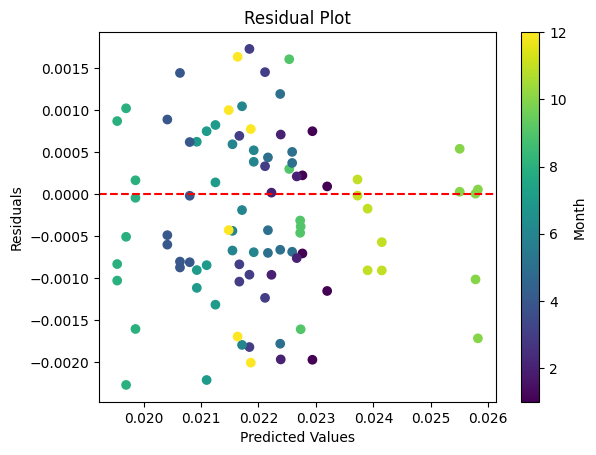

In [18]:
residuals = real - preds
colours = test_set["month"].values
plt.scatter(preds, residuals, c=colours, cmap='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.colorbar(label='Month')
plt.show()


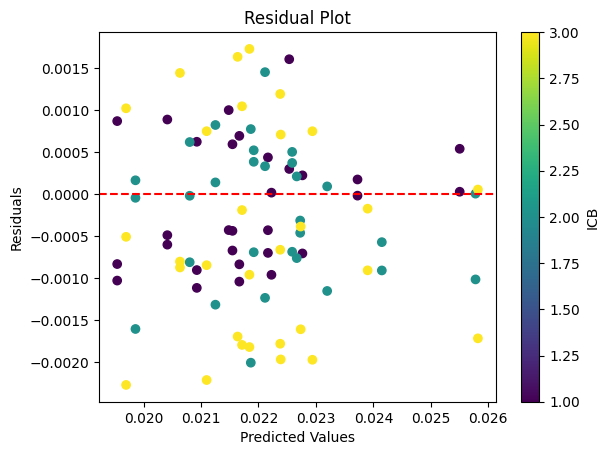

In [19]:
colours = {'06L':1,'06T':2,'07K':3}
plt.scatter(preds, residuals, c=test_set.index.map(colours))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals, Appointments per person per working day')
plt.title('Residual Plot')
plt.colorbar(label='ICB')
plt.show()


### Load population estimate

In [20]:
pop_projections = PopulationScenarios.read_yaml("outputs/population_projections.yaml")
scenario_names = pop_projections.scenarios


In [21]:
base_scenario = pop_projections.get_scenario(scenario_names[0])
base_scenario_df = base_scenario.as_dataframe()

In [22]:
base_scenario_df

age_band                       0-4  10-14  15-19  20-24  25-29  30-34  35-39  \
year area                                                                      
2023 Ipswich & East Suffolk  18229  24199  23630  19792  22842  26241  26908   
     North East Essex        17169  21759  19431  21856  23565  25168  23949   
     West Suffolk            12362  15401  14557  12323  15136  17172  17404   
2024 Ipswich & East Suffolk  18152  24118  23937  19610  22570  26044  27346   
     North East Essex        17255  22079  19943  21815  23496  25184  24732   
...                            ...    ...    ...    ...    ...    ...    ...   
2042 North East Essex        19503  21685  21378  24767  26391  26550  25371   
     West Suffolk            13136  14276  14569  13321  15814  17600  15770   
2043 Ipswich & East Suffolk  19088  21242  21752  20561  23235  26429  25631   
     North East Essex        19665  21793  21410  24614  26203  26750  26077   
     West Suffolk            13235  14318  14546  13219  15683  17721  16204   

age_band                     40-44  45-49    5-9  50-54  55-59  60-64  65-69  \
year area                                                                      
2023 Ipswich & East Suffolk  26854  24765  22372  28239  29602  27494  24061   
     North East Essex        22881  21215  20621  23740  25170  23305  20463   
     West Suffolk            17445  16321  14276  19219  20695  18676  15930   
2024 Ipswich & East Suffolk  26847  24651  21999  27438  29608  28341  24430   
     North East Essex        23081  21281  20419  23136  25331  24083  21012   
...                            ...    ...    ...    ...    ...    ...    ...   
2042 North East Essex        24560  25413  21270  26252  25030  24835  24359   
     West Suffolk            16040  17656  14125  17900  18274  18105  17160   
2043 Ipswich & East Suffolk  24503  26514  20964  26777  27064  27369  25015   
     North East Essex        24254  25315  21485  26169  25483  25376  24142   
     West Suffolk            15813  17571  14250  17635  18529  18491  16724   

age_band                     70-74  75-79  80-84  85-89    90+  
year area                                                       
2023 Ipswich & East Suffolk  22448  21512  13025   8415   4946  
     North East Essex        19688  20146  11973   7232   4099  
     West Suffolk            15478  15487   9501   5722   3003  
2024 Ipswich & East Suffolk  22300  22089  13711   8673   5047  
     North East Essex        19286  20549  12687   7442   4128  
...                            ...    ...    ...    ...    ...  
2042 North East Essex        26155  25145  18905  11407   7712  
     West Suffolk            19374  18567  14239   9026   6277  
2043 Ipswich & East Suffolk  27948  27352  21330  14143  10041  
     North East Essex        25848  25477  19505  11752   7817  
     West Suffolk            19116  18659  14714   9254   6357  

[63 rows x 19 columns]

Transform data